## **Exploración Inicial**

El objetivo de este notebook es realizar un análisis exploratorio de los datos para entender su estructura, distribución y relaciones.

Por medio de este análisis, se busca identificar patrones, tendencias y anomalías en los datos, así como establecer relaciones entre las variables.

**Objetivos:**
- Entender la estructura de los datos
- Identificar patrones y tendencias
- Detectar anomalías y valores atípicos
- Establecer relaciones entre las variables
- Generar insights para la toma de decisiones

### **📚 Librerías**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### **1. Calidad de los datos**

In [2]:
df_feed = pd.read_xml("feed.xml")
df_feed.sample(5)

,state,city,colony,street,external_num,code,type,purpose,price,mail_contact,phone_contact
15499,Yucatán,Mérida,Temozon Norte,,NaN,39555,Casa,Venta,1890000,user-3955@mail.com,35671691
13988,Yucatán,Mérida,Serapio Rendón,"C. 50-a, Fraccionamiento del Sur, 97285 Mérida...",NaN,38652,Departamento,Venta,1435000,user-3865@mail.com,826318
21189,Yucatán,Mérida,Benito Juárez Ote,43,NaN,6890,Casa,Venta,2905000,user-689@mail.com,37279956
13898,Jalisco,San Pedro Tlaquepaque,Los Cajetes,"San Alfonso No. 103-25. Col El campanario, Zap...",NaN,37767,Departamento,Venta,4700000,user-3776@mail.com,39554454
14649,Hidalgo,Pachuca de Soto,La Palma,Cerro de Guadalupe,NaN,14808,Departamento,Venta,1281000,user-1480@mail.com,53426138


#### **1.1 Valores nulos**

Es importante entender la distribución de los datos antes de realizar cualquier análisis. Y uno de los primeros pasos es identificar los posibles valores nulos que puedan existir en el dataset. Con esto podemos identificar si es necesario limpiar los datos o si es posible trabajar con ellos tal cual.

In [3]:
def calculate_null_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula el número y porcentaje de valores nulos por columna en un DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame a analizar
        
    Returns:
        pd.DataFrame: DataFrame con columnas: 'column', 'null_count', 'null_percentage', 'data_type'
    """
    df_nulls = pd.DataFrame()

    # Analisis de columnas
    for column in df.columns:
        
        # Contar valores nulos
        null_count = df[column].isna().sum()
        null_percentage = round((null_count / len(df)) * 100, 2)

        # Tipo de dato
        data_type = df[column].dtype
        
        df_nulls = pd.concat([df_nulls, pd.DataFrame({
            'column': [column],
            'data_type': [data_type],
            'null_count': [null_count],
            'null_percentage': [null_percentage]
        })], ignore_index=True)    

    return df_nulls

In [4]:
calculate_null_values(df_feed)

,column,data_type,null_count,null_percentage
0,state,str,0,0.00
1,city,str,0,0.00
2,colony,str,3,0.01
3,street,str,3392,11.31
4,external_num,str,23118,77.06
5,code,int64,0,0.00
6,type,str,0,0.00
7,purpose,str,0,0.00
8,price,int64,0,0.00
9,mail_contact,str,0,0.00


**Observaciones**

Con esta primera exploración podemos ver que hay valores nulos en las columnas:  
- street (**11.31%**)
- external_num (**77%**)
- colony (**0.01%**)

Por la naturaleza de los datos, es viable hacer un imputado de los valores nulos y agregar una nueva categoría para los valores nulos, "N/A".



In [5]:
# Rellenar valores nulos
df_feed['colony'] = df_feed['colony'].fillna('N/A')
df_feed['external_num'] = df_feed['external_num'].fillna('N/A')
df_feed['street'] = df_feed['street'].fillna('N/A')

In [6]:
calculate_null_values(df_feed)

,column,data_type,null_count,null_percentage
0,state,str,0,0.0
1,city,str,0,0.0
2,colony,str,0,0.0
3,street,str,0,0.0
4,external_num,str,0,0.0
5,code,int64,0,0.0
6,type,str,0,0.0
7,purpose,str,0,0.0
8,price,int64,0,0.0
9,mail_contact,str,0,0.0


Ya tenemos lista una lógica de imputación para los valores nulos.

#### **1.2 Valores duplicados**

Es importante entender bajo que condiciones podemos obtener registros con la misma información con la intención de evitar duplicados y asegurar la integridad de los datos.

In [7]:
def calculate_duplicates_values(df: pd.DataFrame, columns: list):
    """
    Calcula el número de valores duplicados en un DataFrame para las columnas especificadas.
    
    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        columns (list): Lista de nombres de columnas para verificar duplicados.
    
    Returns:
        dict: Un diccionario que contiene el número de duplicados, el total de filas y el porcentaje de duplicados.
    """
    duplicates = df.duplicated(subset=columns).sum()
    total = len(df)
    percentage = round((duplicates / total) * 100, 2)

    resume = {
        "duplicates": duplicates,
        "total": total,
        "percentage": percentage
    }

    return resume

In [8]:
calculate_duplicates_values(
    df_feed, 
    ["state", "city", "colony", "street", "external_num", "code", "type"]
)

{'duplicates': np.int64(4), 'total': 30000, 'percentage': np.float64(0.01)}

In [9]:
# Creación de un hash único para cada propiedad con base a las columnas definidas
columns_to_hash = [
    "state", "city", "colony", "street", "external_num", "code", "type", "price"
]

df_feed['hash_id'] = df_feed[columns_to_hash].apply(lambda x: hash(tuple(x)), axis=1)

In [10]:
df_feed.drop_duplicates(subset=['hash_id'], keep='first', inplace=True)

Identificando variables que por lógica de negocio no deberian contener valores duplicados si los combinamos, con esto se construye un hash para controlar la integridad de la información dentro de la base de datos.

#### **1.3 Outliers**

Otro factor importante para controlar la calidad de los datos viene del comportamiento de los mismos, para ello es importante entender la respectiva distribución para detectar valores extremos o atípicos.

En el caso del ejercicio actual, la única columna que vale la pena analizar es `price`.

<Axes: >

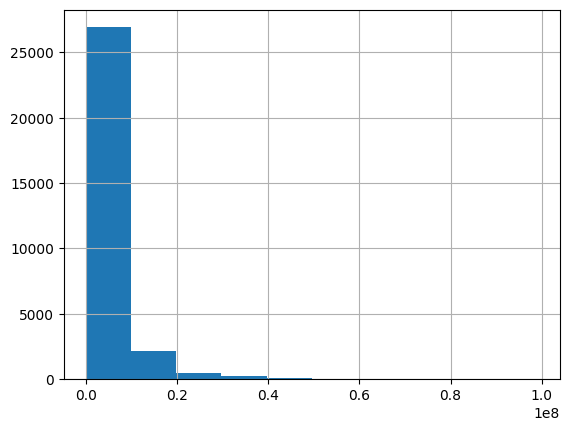

In [34]:
df_feed.query("price < 100_000_000")["price"].hist()

In [39]:
round(len(df_feed.query("price < 100_000_000"))/len(df_feed) * 100, 2)

99.88

Podemos observar que el 99.88% de las propiedades se encuentran por debajo de 100.000.000 dólares, que puede servirnos como un límite superior, lo ideal sería que si se registra alguna propiedad con un precio mayor a este límite, se levante una alerta para revisar si el precio fue ingresado correctamente.